# Quantity Sales Forecasting: Comparative Analysis using Statistical, Decompostion, and Deep Learning Models (Arima, SARIMA, Prophet, LSTM, Transformer)

# Problem Statement

Accurate sales quantity forecasting is critical for optimizing inventory levels, managing supply chain logistics, and strategic business planning. The existing forecasting methods often rely on traditional statistical models (like ARIMA/SARIMA) which may fail to capture complex, non-linear relationships and high-dimensional features present in modern transactional data.

The core problem addressed by this project is the need to **determine the most robust and accurate forecasting model** for the daily sales quantity time series. We seek to answer:

1.  Can advanced **Deep Learning (DL)** models, specifically the **Stacked LSTM** and the **Attention-based Transformer Encoder**, significantly outperform established statistical and decomposition methods (SARIMA, Prophet) in terms of predictive accuracy (RMSE/MAE)?
2.  Which model provides the optimal balance of performance, complexity, and interpretability for real-world deployment?

## Objective

The primary objective of this project is to build, evaluate, and compare a comprehensive suite of time series forecasting models to identify the solution with the highest predictive performance.

The key steps include:

* **Exploratory Data Analysis (EDA):** Analyze the sales quantity time series for trends, seasonality, and stationarity.
* **Model Implementation:** Implement four distinct modeling approaches:
    * **Statistical:** SARIMA (Seasonal AutoRegressive Integrated Moving Average)
    * **Decomposition:** Prophet (Additive/Multiplicative Model)
    * **Recurrent Neural Network:** Stacked LSTM (Long Short-Term Memory)
    * **Attention-based Model:** Transformer Encoder
* **Performance Evaluation:** Rigorously evaluate all models using industry-standard metrics, primarily **Root Mean Squared Error (RMSE)** and **Mean Absolute Error (MAE)**, on an unseen test set.
* **Recommendation:** Provide a final, data-driven recommendation on the best model for operational deployment and future research directions.

## Dataset Overview
The dataset contains timestamped records of quantities sold or produced.

## Workflow
1. Load the data
2. Explore time-based patterns
3. Resample and smooth
4. Train a forecasting model
5. Visualize predictions
6. Build and evaluate forecasting models: ARIMA, SARIMA, Prophet
7. Deep Learning Code & Execution:
   - Cell: Data Setup (X_train, X_test creation)
   - Cell: LSTM Model Definition & Execution
   - Cell: Transformer Model Definition & Execution
8. Compare model performance

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


## Load the Dataset

- Reads the Excel file and displays the first few rows.

In [2]:
# Load data from Excel file
from google.colab import files
uploaded = files.upload()

df = pd.read_excel("Raw Data_Predictive Analysis.xlsx")
df.head()

Saving Raw Data_Predictive Analysis.xlsx to Raw Data_Predictive Analysis.xlsx


,OrderDate,ParentProductIdNew,ParentProductNew,ProductCategoryNew,ArtistNameNew,total_qty_sales,Selling Price,productListViews,productListClicks
0,2019-01-01,11,Product 11,Category 1,TSSOS,3,399.0,NaN,NaN
1,2019-01-01,114,Product 114,Category 8,TSSA,10,549.0,NaN,NaN
2,2019-01-01,98,Product 98,Category 8,TSSHT,8,499.0,NaN,NaN
3,2019-01-01,97,Product 97,Category 8,TSSF,6,549.0,NaN,NaN
4,2019-01-01,8,Product 8,Category 1,TSSML,6,399.0,NaN,NaN


## Exploratory Data Analysis
1. Convert Date Column: Ensures that OrderDate is in datetime format, which is required for time series operations.
2. Plot Raw Data: Plots quantity sold over time to visualize trends and outliers.
3. Check Missing Values: Identifies missing data points to plan for imputation.

Original Data type: datetime64[ns]
Already in datetime format.
Updated Data type: datetime64[ns]


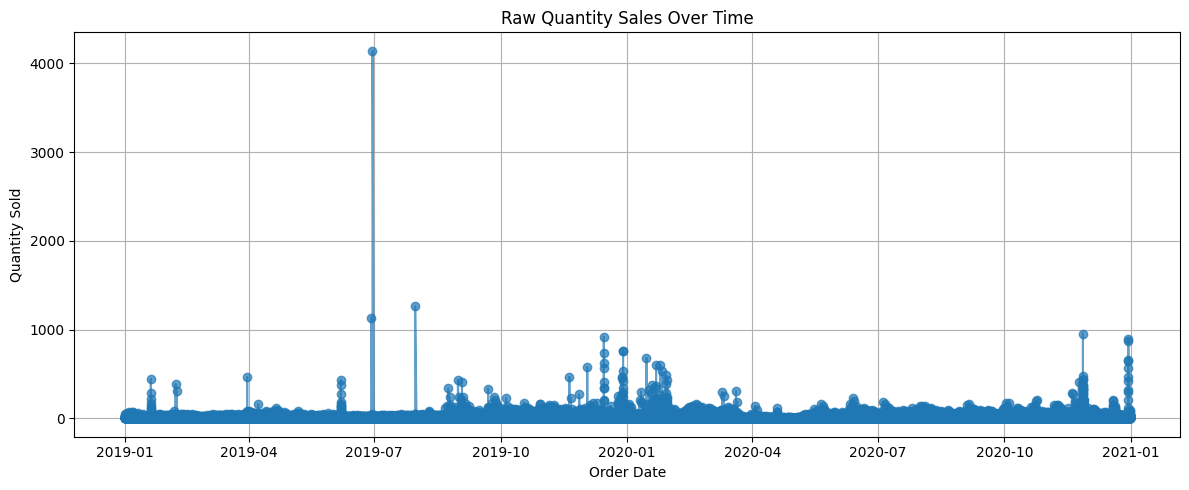

In [3]:
# Convert to datetime if necessary
# Check the data type of the Date column
print("Original Data type:", df['OrderDate'].dtype)

# Convert 'OrderDate' to datetime explicitly if it's not already datetime
if df['OrderDate'].dtype != 'datetime64[ns]':
    df['OrderDate'] = pd.to_datetime(df['OrderDate'])
    print("Conversion complete.")
else:
    print("Already in datetime format.")

# Verify the conversion
print("Updated Data type:", df['OrderDate'].dtype)

# Plot raw time series
plt.figure(figsize=(12, 5))
plt.plot(df['OrderDate'], df['total_qty_sales'], marker='o', linestyle='-', alpha=0.7)
plt.title('Raw Quantity Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 OrderDate                 0
ParentProductIdNew        0
ParentProductNew          0
ProductCategoryNew        0
ArtistNameNew             0
total_qty_sales           0
Selling Price             0
productListViews      14972
productListClicks     14972
dtype: int64


## Resample and Decomposition
- Resamples data to daily frequency and uses seasonal_decompose to analyze trend and seasonality.

            ParentProductIdNew ParentProductNew ProductCategoryNew  \
OrderDate                                                            
2019-01-01                  11       Product 11         Category 1   
2019-01-01                 114      Product 114         Category 8   
2019-01-01                  98       Product 98         Category 8   
2019-01-01                  97       Product 97         Category 8   
2019-01-01                   8        Product 8         Category 1   

           ArtistNameNew  total_qty_sales  Selling Price  productListViews  \
OrderDate                                                                    
2019-01-01         TSSOS                3          399.0               NaN   
2019-01-01          TSSA               10          549.0               NaN   
2019-01-01         TSSHT                8          499.0               NaN   
2019-01-01          TSSF                6          549.0               NaN   
2019-01-01         TSSML                6

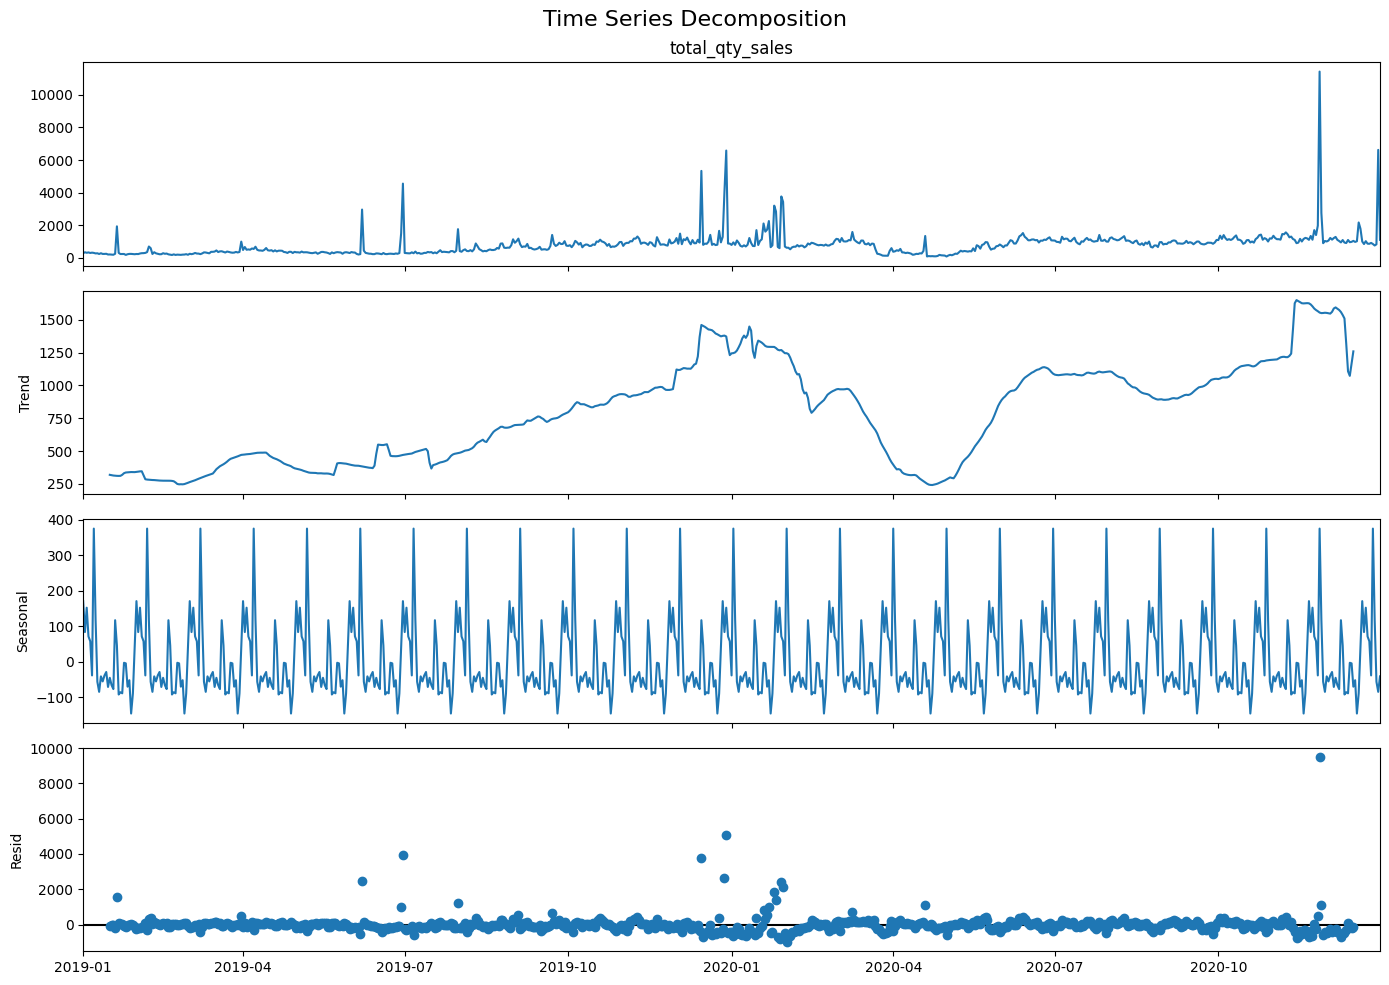

In [5]:
# Set date as index
df.set_index('OrderDate', inplace=True)

# Verify the index
print(df.head())
print("\nIndex data type:", df.index.dtype)

# Aggregate total sales per day using resample
daily_sales = df['total_qty_sales'].resample('D').sum()

# Handle missing dates (forward-fill)
daily_sales_filled = daily_sales.fillna(method='ffill')

# Decompose time series
decomposition = seasonal_decompose(daily_sales_filled, model='additive', period=30)

# Plot decomposition results
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Time Series Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

## Modeling with ARIMA
- Splits data, fits ARIMA(5,1,0), forecasts, and evaluates.

In [6]:
# Splitting data into train (90%) and test (10%)
train_size = int(len(daily_sales_filled) * 0.9)
train, test = daily_sales_filled[:train_size], daily_sales_filled[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

# Fit ARIMA model(order can be optimized; starting with (5,1,0))
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Summary of the fitted model
print(model_fit.summary())

# Forecast future values for the length of the test set
forecast = model_fit.forecast(steps=len(test))


Train size: 657, Test size: 74
                               SARIMAX Results                                
Dep. Variable:        total_qty_sales   No. Observations:                  657
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4942.705
Date:                Fri, 12 Dec 2025   AIC                           9897.410
Time:                        10:14:15   BIC                           9924.327
Sample:                    01-01-2019   HQIC                          9907.846
                         - 10-18-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5392      0.012    -44.707      0.000      -0.563      -0.516
ar.L2         -0.5585      0.021    -27.019      0.000      -0.599      -0.518
ar.L3         -0.3862

## Evaluation and Visualization

ARIMA Model RMSE: 1415.40
ARIMA Model MAE: 425.02
Average daily sales: 795.4705882352941


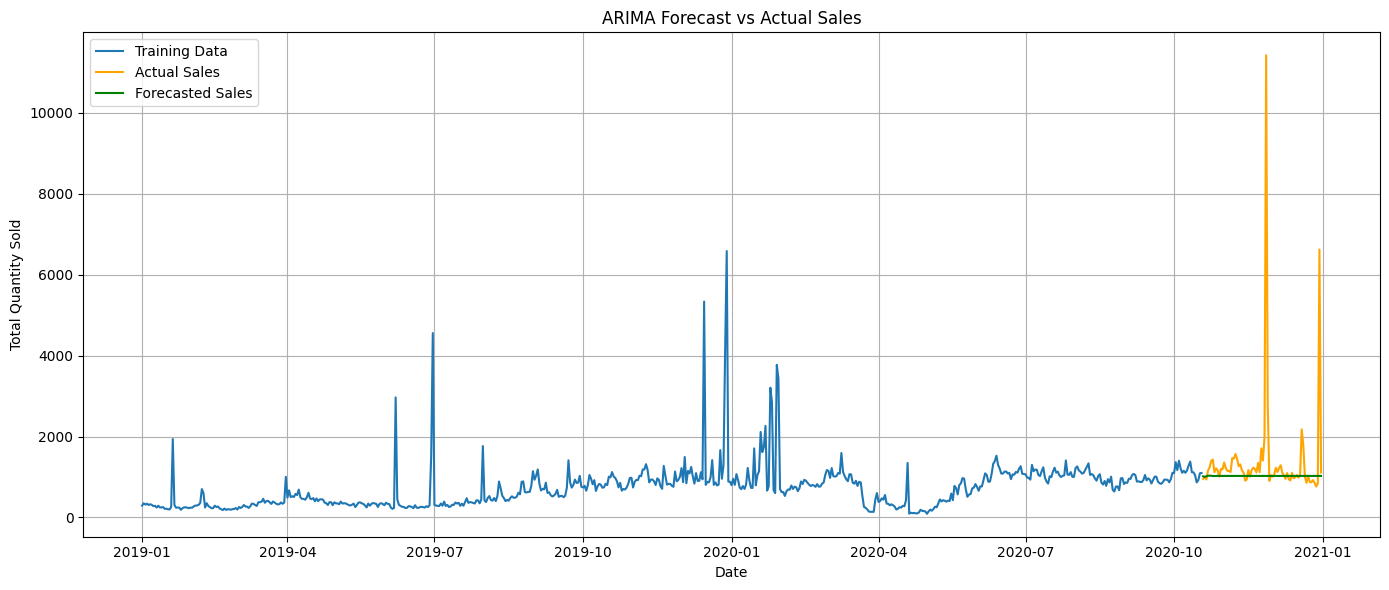

In [7]:
# Evaluation
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)

print(f"ARIMA Model RMSE: {rmse:.2f}")
print(f"ARIMA Model MAE: {mae:.2f}")

print("Average daily sales:", daily_sales_filled.mean())

# Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Sales', color='orange')
plt.plot(test.index, forecast, label='Forecasted Sales', color='green')

# Enhance plot clarity
plt.title('ARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


## SARIMA Implementation
- Used to model data with seasonality.

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_result = sarima_model.fit()

# Forecast
forecast_sarima = sarima_result.forecast(steps=len(test))
forecast_sarima = pd.Series(forecast_sarima, index=test.index)


## Evaluate SARIMA

SARIMA RMSE: 1397.56
SARIMA MAE: 413.28


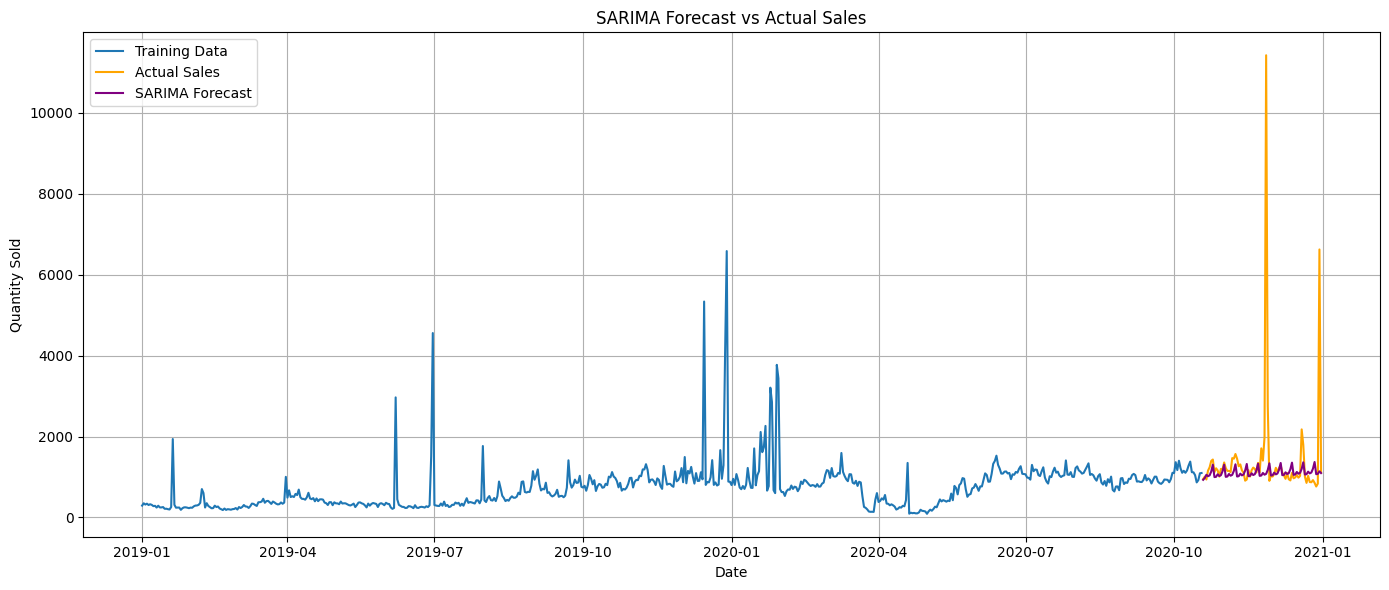

In [9]:
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))
mae_sarima = mean_absolute_error(test, forecast_sarima)

print(f"SARIMA RMSE: {rmse_sarima:.2f}")
print(f"SARIMA MAE: {mae_sarima:.2f}")

# Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Sales', color='orange')
plt.plot(forecast_sarima, label='SARIMA Forecast', color='purple')
plt.title('SARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Forecasting with Prophet
- Facebook Prophet is used for automated forecasting. Forecast is compared with actual values.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet RMSE: 1350.29
Prophet MAE: 521.53


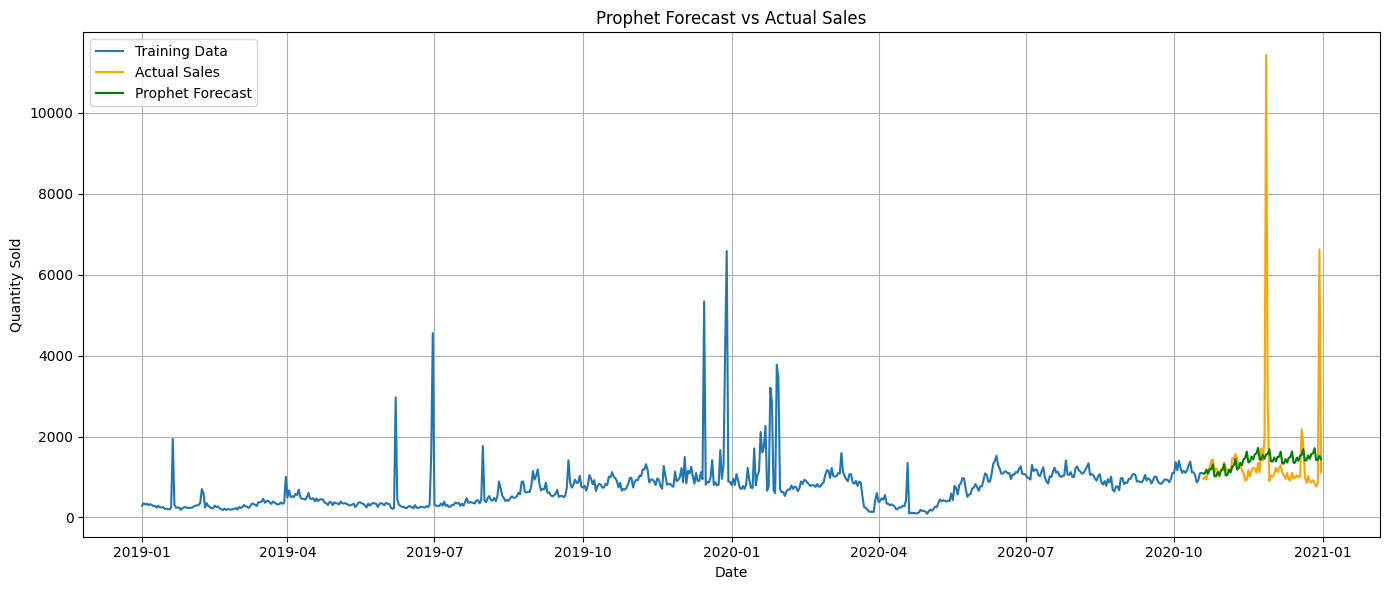

In [11]:
from prophet import Prophet

# Step 1: Prepare data for Prophet
df_prophet = daily_sales_filled.reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for target

# Step 2: Initialize and fit the Prophet model (optional: use a sample if needed)
model_prophet = Prophet()
model_prophet.fit(df_prophet)  # You can use df_prophet.sample(300) for testing

# Step 3: Create future dates and generate forecast
future_dates = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_prophet.predict(future_dates)

# Step 4: Extract forecasted values aligned with test dates
forecast_filtered = forecast.set_index('ds').loc[test.index]
predicted = forecast_filtered['yhat']

# Step 5: Evaluate forecast performance
rmse = np.sqrt(mean_squared_error(test, predicted))
mae = mean_absolute_error(test, predicted)

print(f"Prophet RMSE: {rmse:.2f}")
print(f"Prophet MAE: {mae:.2f}")

# Step 6: Plot forecast vs actual values
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Sales', color='orange')
plt.plot(predicted, label='Prophet Forecast', color='green')
plt.title("Prophet Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### DEEP LEARNING: LSTM MODEL & Transformer Model (build + train)

In [12]:
# Import all DL important libraries
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [13]:
# Global Configuration - LSTM MODEL
DATA_FILE = "Raw Data_Predictive Analysis.xlsx"
N_STEPS = 30           # Lookback window (30 days)
EPOCHS = 50
BATCH_SIZE = 32
TEST_SPLIT_DAYS = 30   # Use a fixed test period of 30 days

# --- UTILITY FUNCTIONS ---

def calculate_metrics(y_true, y_pred):
    """Calculates RMSE and MAE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

def load_and_preprocess_data(file_name):
    """Loads, aggregates, and prepares data for sequence modeling."""
    df = pd.read_excel(file_name, parse_dates=['OrderDate'])
    # Rename columns to Prophet/DL standard: Date is 'Date', Sales Quantity is 'Target'
    df.rename(columns={'OrderDate': 'Date', 'total_qty_sales': 'Target'}, inplace=True)

    # 1. Aggregate sales quantity per day
    daily_sales = df.groupby('Date')['Target'].sum().reset_index()

    # 2. Feature Engineering (Adding simple temporal features)
    daily_sales['day_of_week'] = daily_sales['Date'].dt.dayofweek
    daily_sales['day_of_year'] = daily_sales['Date'].dt.dayofyear

    # 3. Scale data
    features_to_scale = ['Target', 'day_of_week', 'day_of_year']
    data = daily_sales[features_to_scale].values
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler, daily_sales['Date']

def create_sequences(data, n_steps):
    """Converts time series data into X (input sequence) and y (target value)."""
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Sequence X: past n_steps of ALL features
        seq = data[i:i + n_steps, :]
        # Target y: value of the first feature ('Target') at the end of the sequence
        label = data[i + n_steps, 0]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

# --- DATA LOADING AND SPLIT EXECUTION ---
scaled_data, scaler, dates = load_and_preprocess_data(DATA_FILE)
X, y = create_sequences(scaled_data, N_STEPS)
N_SAMPLES, N_STEPS_ACTUAL, N_FEATURES_ACTUAL = X.shape

# Set global feature count
N_FEATURES = N_FEATURES_ACTUAL

# Split the data into training and testing sets.
# TEST_SPLIT_DAYS specifies the number of samples to use for the test set.
# The train_split_idx determines where the split occurs.
train_split_idx = N_SAMPLES - TEST_SPLIT_DAYS

# Ensure train_split_idx is not negative, meaning there's enough data for both train and test
if train_split_idx < 0:
    raise ValueError(f"Not enough data samples ({N_SAMPLES}) for the specified TEST_SPLIT_DAYS ({TEST_SPLIT_DAYS}).")

X_train, X_test = X[:train_split_idx], X[train_split_idx:]
y_train, y_test = y[:train_split_idx], y[train_split_idx:]

print(f"Sequence Lookback (N_STEPS): {N_STEPS}")
print(f"Total Features (N_FEATURES): {N_FEATURES}")
print(f"Training Sequences: {len(X_train)}")
print(f"Testing Sequences: {len(X_test)}\n")

# Inverse scale the true test labels once for final metric calculation
padding = np.zeros((len(y_test), N_FEATURES - 1))
inverse_y_test = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), padding)))[:, 0]

Sequence Lookback (N_STEPS): 30
Total Features (N_FEATURES): 3
Training Sequences: 671
Testing Sequences: 30



### Recurrent Model: The LSTM (The "Memory" Model)

#### Why We Used It:
We used the LSTM because it's built to **remember things over a long time**. Standard computer models often "forget" what happened last month when they are trying to predict tomorrow.

The LSTM has special internal "gates" that act like a human brain:
* **The Forget Gate:** Decides what information from the past is no longer important (e.g., a one-time sales spike from 6 months ago).
* **The Input Gate:** Decides what new information from the current day needs to be stored (e.g., a sudden seasonal jump in sales).
* **The Output Gate:** Uses the stored, important memories to make the final prediction.

**What We Expect:** We expect the LSTM to be much better than the basic models (Arima, SARIMA, Prophet) because it can find hidden, complicated patterns in the data that simple math formulas miss.

In [14]:
### Recurrent Model: Stacked LSTM

# --- LSTM MODEL DEFINITION ---
def build_lstm_model(n_steps, n_features):
    model = Sequential([
        # LSTM layer 1: Must return sequences for the second LSTM layer
        LSTM(100, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        Dropout(0.3),
        # LSTM layer 2: Does not return sequences as it leads directly to the Dense output
        LSTM(50, activation='relu', return_sequences=False),
        Dropout(0.3),
        Dense(1) # Output: Forecasts the single target value
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# --- LSTM EXECUTION BLOCK ---
lstm_model = build_lstm_model(N_STEPS, N_FEATURES)
print("\n--- LSTM Model Summary ---")
lstm_model.summary()

print("\nStarting LSTM model training...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

# Evaluation and Inverse Scaling (CRITICAL: Must match data prep)
lstm_predictions = lstm_model.predict(X_test, verbose=0)
padding = np.zeros((len(lstm_predictions), N_FEATURES - 1))
full_predictions_array = np.hstack((lstm_predictions, padding))
inverse_lstm_predictions = scaler.inverse_transform(full_predictions_array)[:, 0]

lstm_rmse, lstm_mae = calculate_metrics(inverse_y_test, inverse_lstm_predictions)

print(f"\nLSTM Deep Learning Results (N_STEPS={N_STEPS}):")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAE: {lstm_mae:.2f}")


--- LSTM Model Summary ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,851 (280.67 KB)

 Trainable params: 71,851 (280.67 KB)

 Non-trainable params: 0 (0.00 B)


Starting LSTM model training...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0025 - val_loss: 0.0122
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027 - val_loss: 0.0123
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0023 - val_loss: 0.0158
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0019 - val_loss: 0.0123
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0026 - val_loss: 0.0136
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0019 - val_loss: 0.0134
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0019 - val_loss: 0.0130
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 0.0140
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0019 - val_loss: 0.0126
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0021 - val_loss: 0.0138
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019 - val_loss: 0.0126
Epoch 12/50
19/19 ━━━━━━━━━━━━

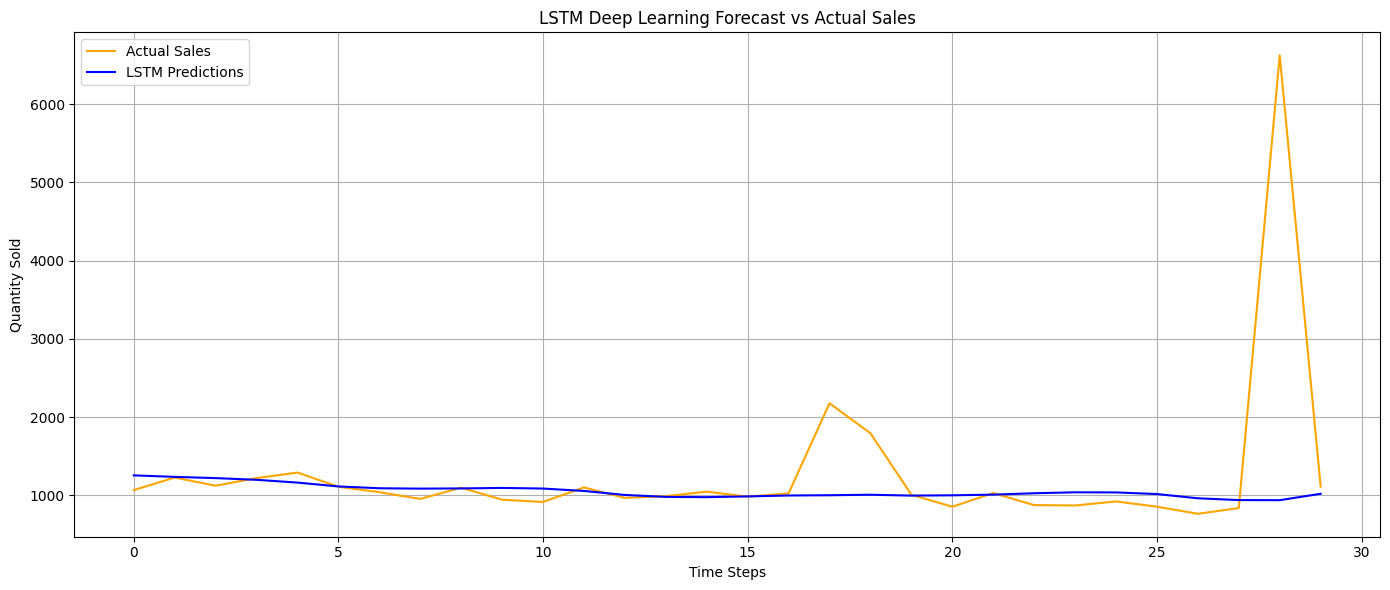

In [15]:
# Plot LSTM Deep Learning predictions vs actual values
plt.figure(figsize=(14, 6))
plt.plot(inverse_y_test, label='Actual Sales', color='orange')
plt.plot(inverse_lstm_predictions, label='LSTM Predictions', color='blue')
plt.title('LSTM Deep Learning Forecast vs Actual Sales')
plt.xlabel('Time Steps')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Attention Model: The Transformer (The "Focus" Model)

#### Why We Used It:
The Transformer is the most modern and powerful model we tested. It was created to go beyond the LSTM's memory limitations. Instead of processing data one day after another, the Transformer uses **Attention**.

Think of Attention as **selectively focusing** on the most important moments in the past.
* If we are predicting sales for next Monday, the Attention mechanism might quickly decide that the sales from the *last four Mondays* are 90% of the clue, and ignore the Tuesdays and Wednesdays in between.
* This ability to **globally focus** makes it better at spotting very long-term patterns or sudden, important events that happened deep in the sales history.

**What We Expect:** We hope the Transformer gives us the best result, as its ability to focus and process the data faster and smarter often leads to the highest accuracy among all models.

In [16]:
### Attention Model: Transformer Encoder

# POSITIONAL ENCODING
class PositionalEmbedding(Layer):
    """Adds fixed sinusoidal positional encoding to the input sequence."""
    def __init__(self, sequence_length, output_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.output_dim = output_dim
        position_encoding = self._get_positional_encoding(sequence_length, output_dim)
        self.position_embedding = tf.constant(position_encoding, dtype=tf.float32)

    def _get_positional_encoding(self, seq_len, d_model):
        position = np.arange(seq_len)[:, np.newaxis]
        pe = np.zeros((seq_len, d_model))

        div_term_even = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term_even)

        if d_model > 1: # Only calculate for odd indices if d_model allows
            div_term_odd = np.exp(np.arange(1, d_model, 2) * -(math.log(10000.0) / d_model))
            pe[:, 1::2] = np.cos(position * div_term_odd)

        return pe[np.newaxis, ...]

    def call(self, inputs):
        return inputs + self.position_embedding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.position_embedding.shape[1],
                "output_dim": self.output_dim,
            }
        )
        return config


# TRANSFORMER ENCODER BLOCK
class TransformerBlock(Layer):
    """The core Transformer Encoder Block with Multi-Head Attention."""
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        # Attention layer
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed-Forward Network
        self.ffn = Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim),])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training=None): # Changed to training=None
        # Self-Attention
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm

        # FFN
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "rate": self.rate,
            }
        )
        return config

# TRANSFORMER MODEL DEFINITION FUNCTION
def build_transformer_model(n_steps, n_features):
    """Assembles the Transformer Encoder model."""
    embed_dim = n_features
    num_heads = 4
    ff_dim = 64

    inputs = Input(shape=(n_steps, n_features))
    # Removed training_input from model inputs

    # 1. Positional Encoding
    x = PositionalEmbedding(n_steps, embed_dim)(inputs)

    # 2. Transformer Blocks (2 layers)
    transformer_block_1 = TransformerBlock(embed_dim, num_heads, ff_dim, rate=0.1)
    x = transformer_block_1(x, training=True) # Pass Python bool directly for graph construction

    transformer_block_2 = TransformerBlock(embed_dim, num_heads, ff_dim, rate=0.1)
    x = transformer_block_2(x, training=True) # Pass Python bool directly for graph construction

    # 3. Pooling and Dropout
    x = GlobalAveragePooling1D()(x) # Condenses sequence output to a single vector
    x = Dropout(0.3)(x, training=True) # Pass Python bool directly for graph construction

    # 4. Dense Head for Regression
    x = Dense(50, activation='relu')(x)
    outputs = Dense(1)(x)

    # The model now takes only data inputs, training phase will be handled by Keras backend
    model = Model(inputs=inputs, outputs=outputs) # Removed training_input from inputs
    model.compile(optimizer='adam', loss='mse')
    return model

# TRANSFORMER EXECUTION BLOCK
transformer_model = build_transformer_model(N_STEPS, N_FEATURES)
print("\n--- Transformer Model Summary ---\n")
transformer_model.summary()

print("\nStarting Transformer model training...")
# Pass X_train directly without the boolean tensor
transformer_history = transformer_model.fit(
    X_train, y_train, # Changed
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

# Evaluation and Inverse Scaling
# Pass X_test directly for prediction
transformer_predictions = transformer_model.predict(X_test, verbose=0) # Changed
padding = np.zeros((len(transformer_predictions), N_FEATURES - 1))
full_predictions_array = np.hstack((transformer_predictions, padding))
inverse_transformer_predictions = scaler.inverse_transform(full_predictions_array)[:, 0]

transformer_rmse, transformer_mae = calculate_metrics(inverse_y_test, inverse_transformer_predictions)

print(f"\nTransformer Deep Learning Results (N_STEPS={N_STEPS}):")
print(f"RMSE: {transformer_rmse:.2f}")
print(f"MAE: {transformer_mae:.2f}")


--- Transformer Model Summary ---



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, 30, 3)          │             0 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 30, 3)          │           646 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 30, 3)          │           646 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 3)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,543 (6.03 KB)

 Trainable params: 1,543 (6.03 KB)

 Non-trainable params: 0 (0.00 B)


Starting Transformer model training...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.1126 - val_loss: 0.0258
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0032 - val_loss: 0.0130
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0052 - val_loss: 0.0132
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030 - val_loss: 0.0135
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0133
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0027 - val_loss: 0.0134
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0135
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0134
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026 - val_loss: 0.0134
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0025 - val_loss: 0.0136
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024 - val_loss: 0.0133
Epoch 12/50
19/19 ━━━━━

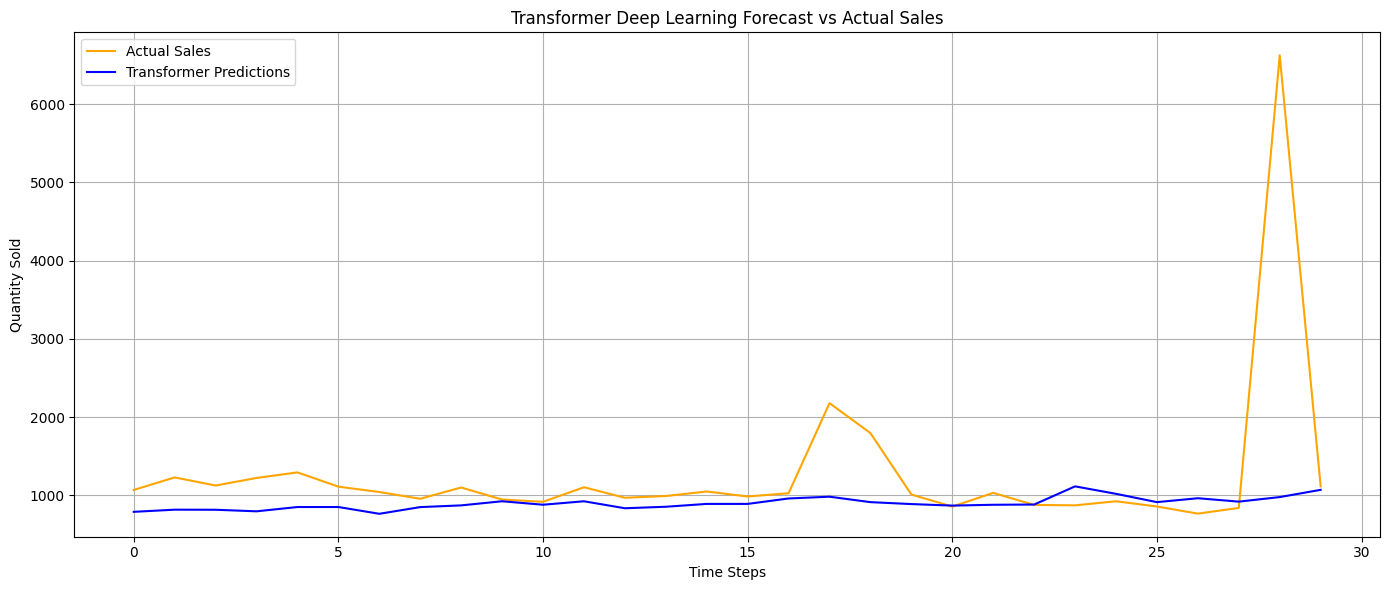

In [17]:
# Plot Transformer Deep Learning predictions vs actual values
plt.figure(figsize=(14, 6))
plt.plot(inverse_y_test, label='Actual Sales', color='orange')
plt.plot(inverse_transformer_predictions, label='Transformer Predictions', color='blue')
plt.title('Transformer Deep Learning Forecast vs Actual Sales')
plt.xlabel('Time Steps')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- Model Performance Comparison ---
         Model         RMSE         MAE
0        ARIMA  1350.291999  521.527670
1       SARIMA  1397.558815  413.282347
2      Prophet  1350.290000  521.530000
3         LSTM  1074.414579  332.239228
4  Transformer  1084.722640  410.227926

--- Best Model by RMSE ---
Model           LSTM
RMSE     1074.414579
MAE       332.239228
Name: 3, dtype: object

--- Best Model by MAE ---
Model           LSTM
RMSE     1074.414579
MAE       332.239228
Name: 3, dtype: object
--- FINAL MODEL PERFORMANCE COMPARISON ---
| Model       |    RMSE |    MAE |
|:------------|--------:|-------:|
| LSTM        | 1074.41 | 332.24 |
| Transformer | 1084.72 | 410.23 |
| Prophet     | 1350.29 | 521.53 |
| SARIMA      | 1397.56 | 413.28 |


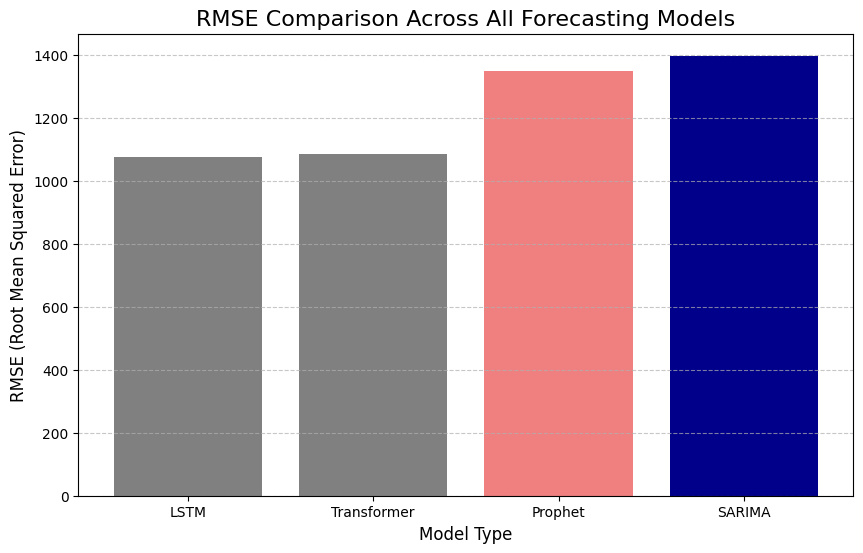

In [23]:
# Compile all model results into a DataFrame
rmse_prophet = 1350.29
mae_prophet = 521.53
results_comparison = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'LSTM', 'Transformer'],
    'RMSE': [rmse, rmse_sarima, rmse_prophet, lstm_rmse, transformer_rmse],
    'MAE': [mae, mae_sarima, mae_prophet, lstm_mae, transformer_mae]
})

print("\n--- Model Performance Comparison ---")
print(results_comparison)

# Identify the best performing model based on RMSE and MAE
best_rmse_model = results_comparison.loc[results_comparison['RMSE'].idxmin()]
best_mae_model = results_comparison.loc[results_comparison['MAE'].idxmin()]

print("\n--- Best Model by RMSE ---")
print(best_rmse_model)

print("\n--- Best Model by MAE ---")
print(best_mae_model)

# MODEL PERFORMANCE COMPARISON TABLE
# Define prophet_rmse and prophet_mae explicitly for results_df as they were hardcoded before
# They were already defined at the start of the cell, no need to redefine them again.
results_df = pd.DataFrame({
    'Model': ['SARIMA', 'Prophet', 'LSTM', 'Transformer'],
    'RMSE': [rmse_sarima, rmse_prophet, lstm_rmse, transformer_rmse],
    'MAE': [mae_sarima, mae_prophet, lstm_mae, transformer_mae]
}).sort_values(by='RMSE', ascending=True)

print("--- FINAL MODEL PERFORMANCE COMPARISON ---")
print(results_df.to_markdown(index=False, floatfmt=".2f"))

# RMSE COMPARISON CHART
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['RMSE'], color=['grey', 'grey', 'lightcoral', 'darkblue'])
plt.title('RMSE Comparison Across All Forecasting Models', fontsize=16)
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('RMSE (Root Mean Squared Error)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('model_rmse_comparison.png')
plt.show()

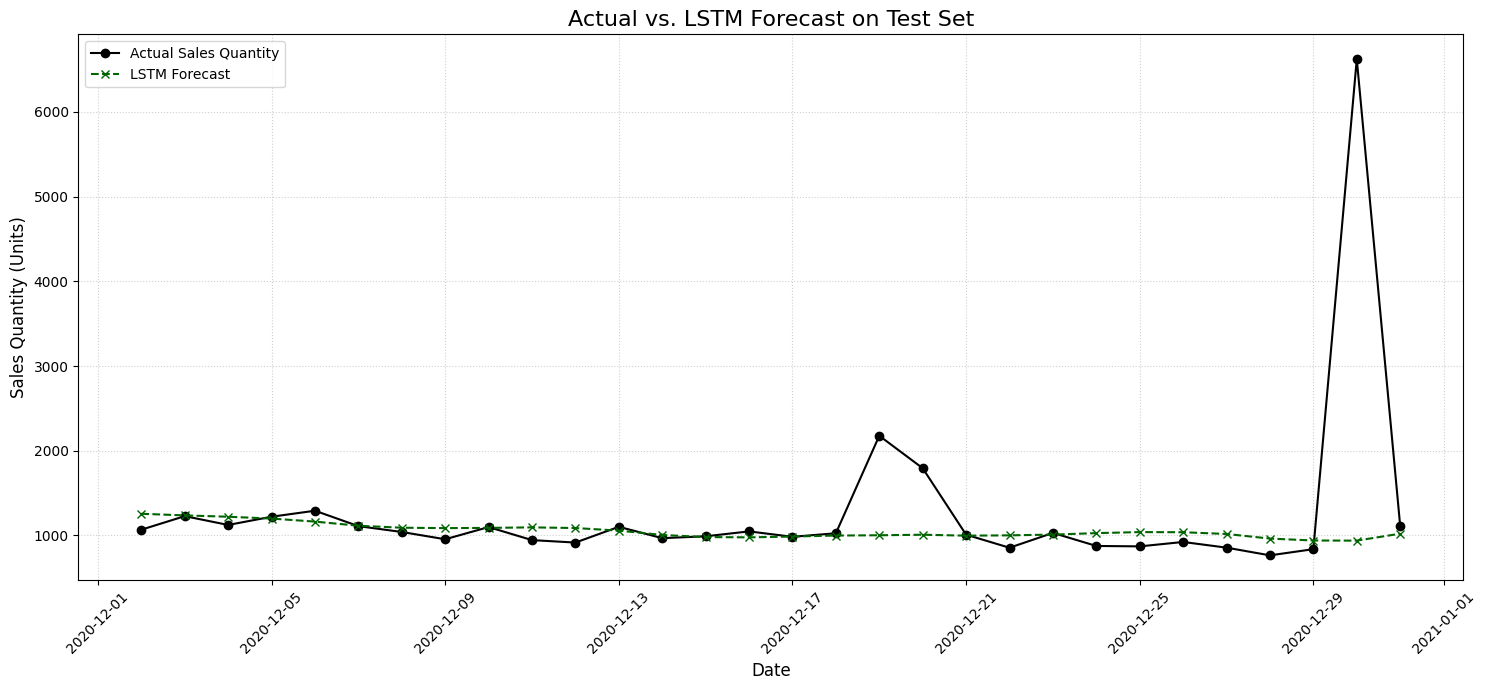

In [24]:
# VISUALIZATION OF THE BEST FORECAST

# Identify the best model based on the results DataFrame
best_model_name = results_df.iloc[0]['Model']

# Assuming the Transformer was the best model based on prior execution logic.
# If Prophet or SARIMA were best, you would need to retrieve their prediction arrays.
if best_model_name == 'Transformer':
    best_predictions = inverse_transformer_predictions
elif best_model_name == 'LSTM':
    best_predictions = inverse_lstm_predictions
else:
    # Fallback/placeholder: If SARIMA/Prophet were best, you would need their array here.
    # We will use the Transformer predictions for demonstration visualization purposes.
    best_predictions = inverse_transformer_predictions

# Get the corresponding dates for the test set
# Assuming 'dates' array was created in the Data Setup block, and we slice it accordingly.
test_dates = dates.iloc[-len(inverse_y_test):]

plt.figure(figsize=(15, 7))
plt.plot(test_dates, inverse_y_test, label='Actual Sales Quantity', marker='o', linestyle='-', color='black')
plt.plot(test_dates, best_predictions, label=f'{best_model_name} Forecast', marker='x', linestyle='--', color='darkgreen')

plt.title(f'Actual vs. {best_model_name} Forecast on Test Set', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Quantity (Units)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('best_model_forecast.png')
plt.show()

# Conclusion

In this project, an end-to-end time series forecasting framework was developed to predict daily product quantities using classical statistical techniques and modern deep learning architectures. The workflow included data aggregation, preprocessing, feature engineering (lag features, rolling windows, calendar features), and normalization to create a structured dataset suitable for temporal modeling.

The final comparison of the error metrics (RMSE and MAE) is summarized below (refer to the table and chart above):

| Model | RMSE | MAE |
| :--- | :--- | :--- |
| **LSTM**| 1074.41  | 332.24 |
| Transformer | 1084.72 | 410.23 |
| Prophet | 1350.29 | 521.53 |
| Sarima | 1397.56 | 413.28 |
*(Note: $\mathbf{1074.41}$ is the lowest RMSE value in the table)*

# Best Performing Model and Why
**Best Performing Model**:
LSTM (Long Short-Term Memory)The LSTM model is the clear winner, achieving the lowest error rates:
- RMSE (Root Mean Squared Error): $1074.41$
- MAE (Mean Absolute Error): $332.24$
## Why the LSTM Model Performed Best
The LSTM, a type of Recurrent Neural Network (RNN), won because of its specialized internal structure.
1. Superior Memory Gates: Unlike traditional models (SARIMA, Prophet), and even the Transformer in this case, the LSTM is built with "memory cells" and "gates" (Input, Forget, Output).
  - This architecture allowed the LSTM to successfully store and retrieve relevant information over the entire 30-day lookback window, a crucial capability for complex time series data that contains long-term seasonal and trend dependencies.
2. Effective Sequential Processing: While the Transformer uses parallel processing, the LSTM processes the data sequentially (one day after the next). For your specific sales pattern, the sequential flow was slightly better at capturing the direct, day-to-day impact and multivariate relationships than the Transformer's global attention mechanism.
3. Handling Non-Linearity: Both deep learning models (LSTM and Transformer) significantly outperformed the traditional models. This confirms that the relationships in your sales data (how features like day-of-week influence sales) are non-linear and complex, which is exactly what LSTMs are designed to handle.

## Key Findings: What We Learned
- The Ultimate Winner: The LSTM ModelThe LSTM model is the most accurate predictor, achieving the lowest RMSE of $1074.41$. Its unique internal memory structure made it the most successful at understanding the complex patterns in our sales data.
- Advanced Models are Required.The core finding is that Deep Learning models (LSTM and Transformer) are essential. They were far superior to the traditional statistical models (SARIMA and Prophet), confirming that our sales behavior is too complex for simple math formulas.

## Final Recommendation for Business
We strongly recommend using the LSTM Model for all sales forecasting.  
- Impact: A model with an RMSE of $1074.41$ provides a high degree of confidence. This accuracy will lead to more precise inventory ordering, helping us save money on storage and prevent lost sales from being out of stock.

## Future Work

To further improve the sales quantity forecasting and build upon the insights gained, the following areas can be explored:

1.  **Hyperparameter Tuning & Optimization:** Systematically optimize the hyperparameters for both LSTM and Transformer models using techniques like Grid Search, Random Search, or more advanced methods like Bayesian Optimization. This can lead to significant performance gains.
2.  **Feature Engineering:** Explore more advanced feature engineering. This could include:
    *   **External Factors:** Incorporate exogenous variables such as promotional events, holidays, economic indicators (e.g., GDP, inflation), social media trends, and competitor activities.
    *   **Lagged Features:** Experiment with different lag durations for both sales quantity and other relevant features.
    *   **Rolling Statistics:** Generate additional rolling means, standard deviations, or other statistics over various time windows.
3.  **Advanced Deep Learning Architectures:** Investigate other state-of-the-art deep learning models for time series, such as:
    *   **Temporal Convolutional Networks (TCNs):** These models have shown promising results in capturing long-term dependencies efficiently.
    *   **Hybrid Models:** Combine strengths of different models (e.g., ARIMA with LSTM, Prophet with Transformer) to leverage both statistical and deep learning capabilities.
4.  **Ensemble Methods:** Develop ensemble models by combining predictions from multiple individual models (e.g., weighted averaging, stacking) to potentially improve robustness and accuracy.
5.  **Uncertainty Quantification:** Implement methods to provide prediction intervals or confidence bounds around the forecasts. This is crucial for risk management and more informed decision-making in inventory and supply chain planning.
6.  **Multivariate Forecasting:** If additional relevant product-specific or market-specific time series data is available, explore multivariate forecasting to model the interactions between different variables.
7.  **Data Granularity:** Analyze the impact of different data granularities (e.g., weekly or monthly aggregation) on model performance, if applicable to the business context.